In [1]:
%run ../../base-notebook.ipynb

--2023-05-11 10:04:42--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11115 (11K) [text/plain]
Saving to: ‘ml_util.py’

ml_util.py          100%[===================>]  10.85K  --.-KB/s    in 0s      

2023-05-11 10:04:42 (70.1 MB/s) - ‘ml_util.py’ saved [11115/11115]

--2023-05-11 10:04:42--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1504 (1.5K) [text/plain]
Saving to: ‘ml_io.py’


In [2]:
import sys

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_layer as mll
import ext.ml_util as mlu

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras import backend as K
from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, RandomFlip, RandomZoom, RandomHeight, RandomWidth, RandomRotation, Input, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.utils import image_dataset_from_directory

TensorFlow version: 2.12.0
Python version 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download our dataset, extract and list contents

In [3]:
mli.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip',
                   './10_food_classes_10_percent.zip')
mli.extract_zip(filepath='10_food_classes_10_percent.zip')
mli.list_dir_summary('./10_food_classes_10_percent')

There are 2 directories, and 0 in ./10_food_classes_10_percent
There are 10 directories, and 0 in ./10_food_classes_10_percent/test
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/chicken_wings
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/fried_rice
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/ice_cream
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/grilled_salmon
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/chicken_curry
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/hamburger
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/steak
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/pizza
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/sushi
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/ramen
There are 10 directories, and 0 in ./10_food_classes_10_percent/train


In [4]:
train_dir = './10_food_classes_10_percent/train'
test_dir = './10_food_classes_10_percent/test'

## Load the data

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical',
                                                     batch_size=BATCH_SIZE
                                                     )

test_data_10_percent = image_dataset_from_directory(directory=test_dir,
                                                    image_size=IMG_SIZE,
                                                    label_mode='categorical',
                                                    batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Display class names

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Create functional model based on the EfficientNet B0 Model.

In [8]:
# 1. Create a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If your using ResMet50V2 you will need to normalize inputs (you don't have to for efficientnet,
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the models
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
print(f"Shape after passing through GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

tensorboard_callback = mlc.create_tensorboard_callback(experiment_name="model_0", dir_name="./logs")


# 10. Fit the model
model_0_history = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25 * len(test_data_10_percent)),
                              callbacks=[tensorboard_callback])

K.clear_session()

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after passing through GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ./logs/model_0/20230511-100504


Epoch 1/5
24/24 [==============================] - 27s 238ms/step - loss: 1.8606 - accuracy: 0.4347 - val_loss: 1.2838 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 5s 157ms/step - loss: 1.0866 - accuracy: 0.7760 - val_loss: 0.8482 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 5s 175ms/step - loss: 0.7792 - accuracy: 0.8400 - val_loss: 0.6784 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 7s 287ms/step - loss: 0.6322 - accuracy: 0.8747 - val_loss: 0.6011 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 4s 135ms/step - loss: 0.5390 - accuracy: 0.8893 - val_loss: 0.5608 - val_accuracy: 0.8602


## Plot model history and accuracy

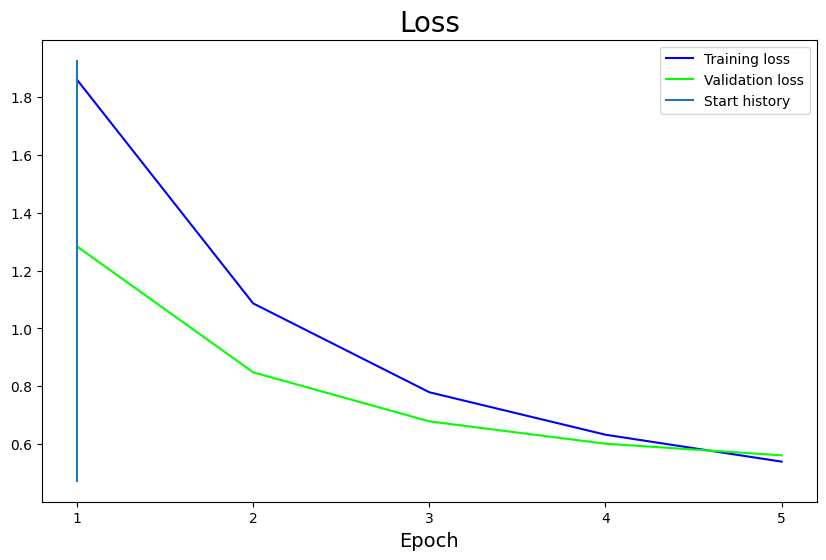

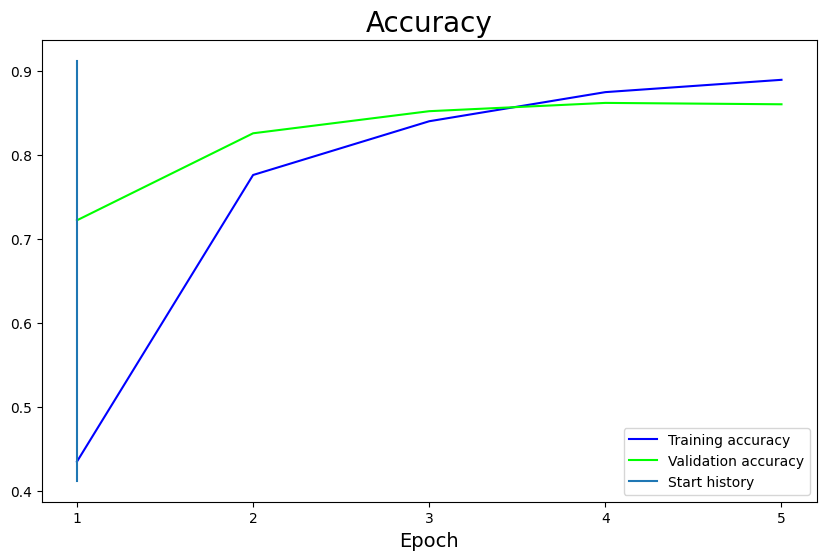

In [9]:
mlu.plot_history(model_0_history)

In [10]:
model_0_evaluation = model_0.evaluate(test_data_10_percent)
model_0_evaluation

79/79 [==============================] - 8s 86ms/step - loss: 0.5659 - accuracy: 0.8596


[0.5658771991729736, 0.8596000075340271]

## Display model details

In [11]:
mll.list_layers(model_0, recursive=True, include_trainable=True, include_non_trainable=True)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
2     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
3     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
4     | rescaling_1               (Rescaling             ) | False     | (None, None, None, 3)   
5     | stem_conv_pad             (ZeroPadding2D         ) | False     | (None, None, None, 3)   
6     | stem_conv                 (Conv2D                ) | False     | (None, None, None, 32)  
7     | stem_bn                   (BatchNormalization    ) | False     | (None, None, None, 32)  
8     | stem_activation           (Activation            ) | False     | (None, None, None, 32)  
9     | block1a_dwconv          

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling2D layer.

We have a tensor after our model goes through `base_model` of shape (7, 7, 1288).

But then when it passes through GlobalAveragePooling2D it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it thourgh GlobalAveragePooling2D

In [13]:
# Define the input shape
INPUT_SHAPE = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(INPUT_SHAPE)

print(f"Random input tensor:\n{input_tensor}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [14]:
# Pass the random tenstor through a GlobalAveragePooling2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D().call(input_tensor)

print(
    f"2D Global average pooled random tensor:\n{global_average_pooled_tensor}\n\nShape:\n{global_average_pooled_tensor.shape}")

2D Global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape:
(1, 3)


In [15]:
# Let's replicate the global average pool 2D layer.
tf.reduce_mean(input_tensor, axis=(1, 2))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [16]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D().call(input_tensor)
print(
    f"2D Global max pooled random tensor:\n{global_max_pooled_tensor}\n\nShape:\n{global_average_pooled_tensor.shape}")


2D Global max pooled random tensor:
[[0.9058464 1.1603122 1.6994323]]

Shape:
(1, 3)


## Running a series of transfer learning experiments.

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... How about we setup a bunch of experiments to find out.

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. 'model_2' - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation

Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation matrics.

In [17]:
# Download the 1% dataset
mli.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip',
                   './10_food_classes_1_percent.zip')
mli.extract_zip(filepath='10_food_classes_1_percent.zip')
mli.list_dir_summary('./10_food_classes_1_percent')

There are 2 directories, and 0 in ./10_food_classes_1_percent
There are 10 directories, and 0 in ./10_food_classes_1_percent/test
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/chicken_wings
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/fried_rice
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/ice_cream
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/grilled_salmon
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/chicken_curry
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/hamburger
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/steak
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/pizza
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/sushi
There are 0 directories, and 250 in ./10_food_classes_1_percent/test/ramen
There are 10 directories, and 0 in ./10_food_classes_1_percent/train
There are 0 d

In [18]:
train_dir = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [19]:
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical')

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          batch_size=BATCH_SIZE,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode='categorical')



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation:

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewere.

In [20]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms, etc..
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(factor=.2),
    RandomZoom(.2),
    RandomHeight(.2),
    RandomWidth(.2),
    # Rescaling(1./255) # Keep for models like ResNet50V2, but EfficientNetB0 does not need this.
], name="data-augmentation")

### Visualize our data augmentation layer

  [112 131 109]
  [115 134 114]
  ...
  [ 34  36  22]
  [ 28  31  14]
  [ 28  31  12]]

 [[113 132 110]
  [111 130 108]
  [114 133 113]
  ...
  [ 36  38  24]
  [ 37  40  23]
  [ 41  44  25]]

 [[109 128 106]
  [111 130 108]
  [119 136 117]
  ...
  [ 48  52  37]
  [ 45  49  32]
  [ 44  48  31]]

 ...

 [[134 144 133]
  [135 145 134]
  [135 145 134]
  ...
  [221 230 227]
  [225 234 231]
  [224 230 228]]

 [[135 145 134]
  [135 145 134]
  [135 145 134]
  ...
  [212 221 218]
  [220 229 226]
  [225 231 229]]

 [[136 144 133]
  [136 144 133]
  [136 144 133]
  ...
  [224 233 230]
  [225 234 231]
  [224 230 228]]]. Consider rewriting this model with the Functional API.


10_food_classes_1_percent/train/hamburger


(-0.5, 543.5, 320.5, -0.5)

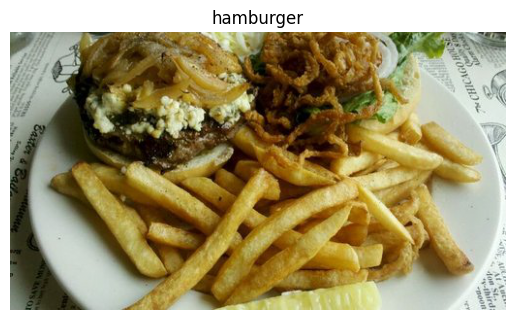

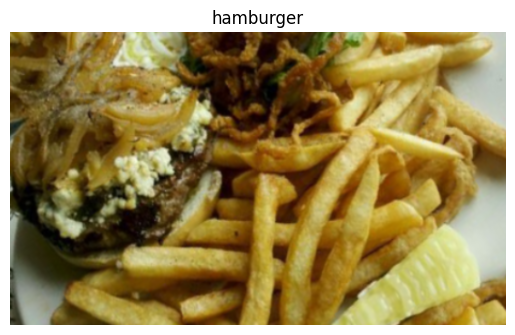

In [21]:
# View a random image and compare it to its augmented version
import os
import random

target_class = random.choice(train_data_1_percent.class_names)

target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.title(target_class)
plt.imshow(img / 255.)
plt.axis(False)

augmented_img = data_augmentation.call(img, training=True)
plt.figure()
plt.title(target_class)
plt.imshow(augmented_img / 255.)
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [22]:
# Setup input shape and base model
INPUT_SHAPE = (224, 224, 3)

In [23]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = Input(shape=INPUT_SHAPE, name="Input Layer")

# Add in data augmentation Sequential
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put a dense layer on as the output layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs / outputs.
model_1 = Model(inputs, outputs)

# Compile the model
model_1.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

tensorboard_callback = mlc.create_tensorboard_callback(experiment_name="model_1", dir_name="./logs")

model_1_history = model_1.fit(train_data_1_percent, steps_per_epoch=len(train_data_1_percent),
                              epochs=5,
                              validation_data=test_data_1_percent,
                              validation_steps=int(0.25 * len(test_data_1_percent)),
                              callbacks=[tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_1/20230511-100616
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3590 - accuracy: 0.0857 - val_loss: 2.2918 - val_accuracy: 0.1447
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1041 - accuracy: 0.2000 - val_loss: 2.1692 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.9059 - accuracy: 0.4571 - val_loss: 2.0523 - val_accuracy: 0.3076
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7400 - accuracy: 0.5571 - val_loss: 1.9326 - val_accuracy: 0.4095
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5639 - accuracy: 0.6714 - val_loss: 1.8644 - val_accuracy: 0.4457


In [24]:
# Check model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentation (Sequenti  multiple                 0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [25]:
# Evaluate on full data set
model_1_evaluation = model_1.evaluate(test_data_1_percent)
model_1_evaluation

79/79 [==============================] - 7s 79ms/step - loss: 1.8515 - accuracy: 0.4420


[1.851458191871643, 0.44200000166893005]

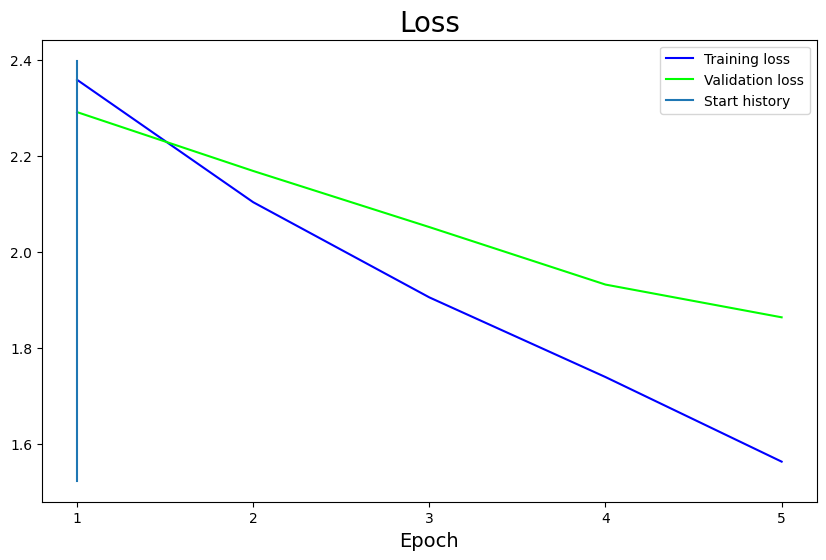

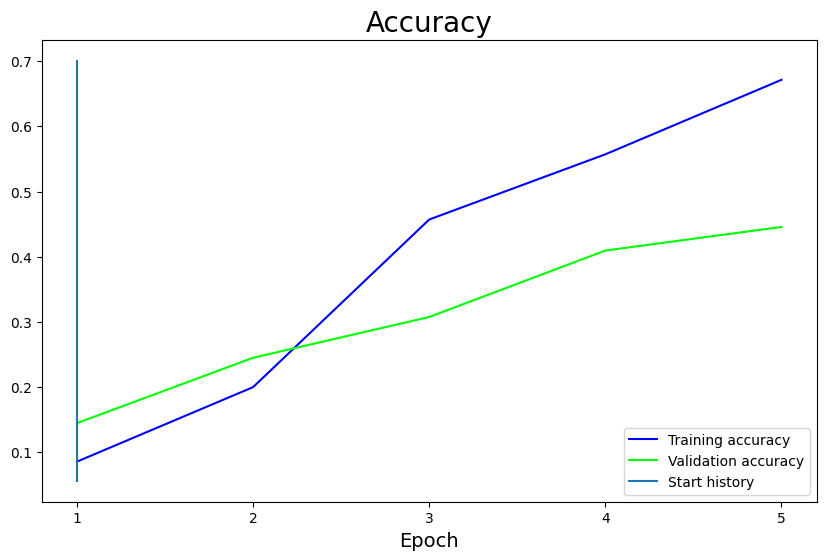

In [26]:
mlu.plot_history(model_1_history)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [27]:
# Get 10% of data
# mlio.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip', './10_food_classes_10_percent.zip')
# mlio.extract_zip(filepath='10_food_classes_10_percent.zip')
# mlio.list_dir_summary('./10_food_classes_10_percent')

In [28]:
train_dir = './10_food_classes_10_percent/train'
test_dir = './10_food_classes_10_percent/test'

In [29]:
# Set data inputs
IMG_SIZE = (224, 224)

train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     label_mode='categorical',
                                                     image_size=IMG_SIZE,
                                                     batch_size=32)

test_data_10_percent = image_dataset_from_directory(directory=test_dir,
                                                    label_mode='categorical',
                                                    image_size=IMG_SIZE,
                                                    batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
# Create model 2 with data augmentation

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(.2),
    RandomWidth(.2),
    RandomRotation(.2),
    RandomZoom(.2),
    # Rescaling(1/.255) # if you're using a model such as ResNet50V2, you'll need to rescale the data
], name="data_augemtation")

In [31]:
INPUT_SHAPE = IMG_SIZE + (3,)

# Create a frozen base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs including the layers in between.
inputs = Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(inputs)  # Augmentation doesn't occure on test data
x = base_model(x,
               training=False)  # Pass augmented images to base model but keep the base model in inference mode, this also insures batchnorm layers don't get updated
x = GlobalAveragePooling2D(name='global_average_pooling_2d')(x)

outputs = Dense(10, activation="softmax", name="output_layer")(x)

model_2 = Model(inputs, outputs)

model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [32]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augemtation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### Creating a ModelCheckpoint callback and fit model 2

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is usefull so we can come back and start where we left off.

In [33]:
initial_epochs = 5

checkpoint_callback = mlc.create_model_checkpoint_callback(experiment_name='model_2_aug_10_percent', save_weights_only=True)
tensorboard_callback = mlc.create_tensorboard_callback('model_2')

model_2_history = model_2.fit(train_data_10_percent, steps_per_epoch=len(train_data_10_percent),
                              epochs=initial_epochs,
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25 * len(test_data_10_percent)),
                              callbacks=[checkpoint_callback, tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_2/20230511-100701


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0374 - accuracy: 0.3160
Epoch 1: saving model to ./checkpoints/model_2_aug_10_percent/model-epoch-01-val_loss-1.47.hdf5
24/24 [==============================] - 23s 660ms/step - loss: 2.0374 - accuracy: 0.3160 - val_loss: 1.4682 - val_accuracy: 0.6546
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3345 - accuracy: 0.6853
Epoch 2: saving model to ./checkpoints/model_2_aug_10_percent/model-epoch-02-val_loss-0.99.hdf5
24/24 [==============================] - 13s 512ms/step - loss: 1.3345 - accuracy: 0.6853 - val_loss: 0.9943 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0047 - accuracy: 0.7667
Epoch 3: saving model to ./checkpoints/model_2_aug_10_percent/model-epoch-03-val_loss-0.79.hdf5
24/24 [==============================] - 12s 481ms/step - loss: 1.0047 - accuracy: 0.7667 - val_loss: 0.7923 - val_accuracy: 0.8059
Epoch 4/5
24/24 [====================

In [34]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 67ms/step - loss: 0.5659 - accuracy: 0.8596


[0.5658773183822632, 0.8596000075340271]

In [35]:
model_2_evaluation = model_2.evaluate(test_data_10_percent)
model_2_evaluation

79/79 [==============================] - 6s 69ms/step - loss: 0.6388 - accuracy: 0.8364


[0.6387568116188049, 0.8363999724388123]

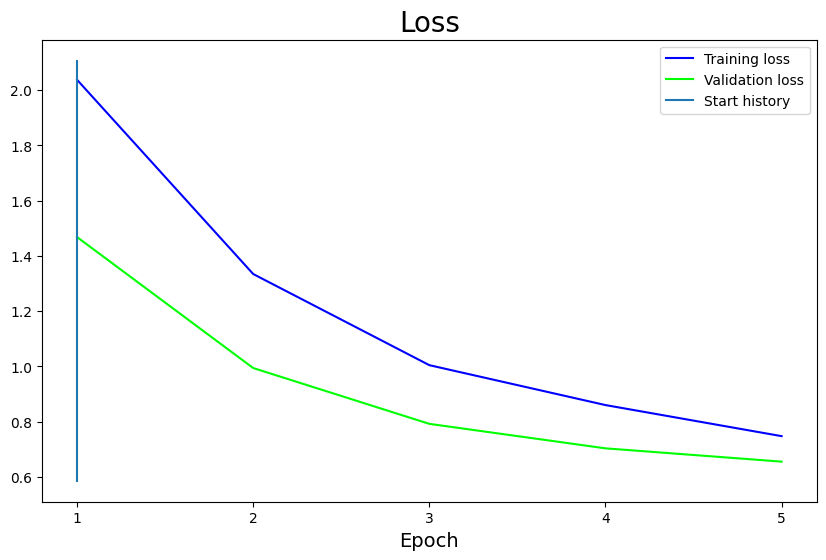

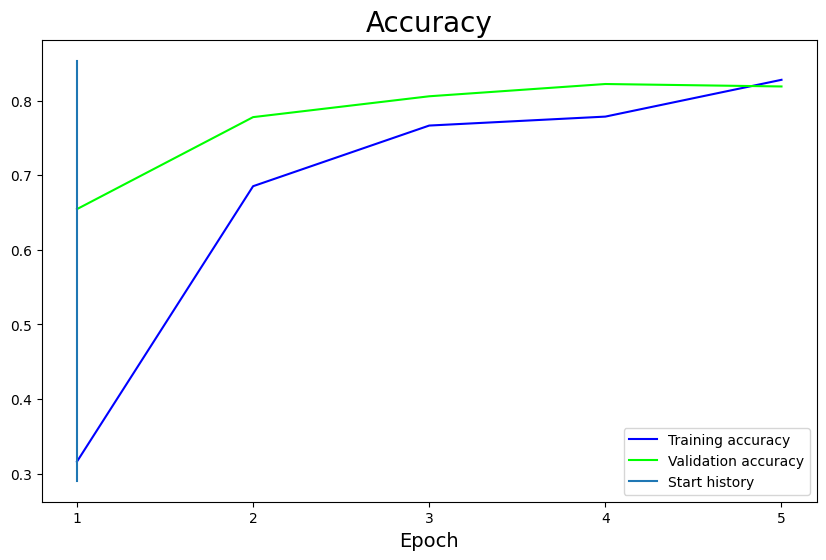

In [36]:
mlu.plot_history(model_2_history)

### Loading in checkpointed weights

Loading in checkpointed weights returns our model to a specific checkpoint.

In [37]:
mll.list_model(model_2, recursive=True, include_trainable=True, include_non_trainable=True)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [38]:
# Load in saves models weights and evaluate model
mll.load_weights(model_2, '/content/checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.66.hdf5')

In [39]:
mll.list_model(model_2, recursive=True, include_trainable=True, include_non_trainable=True)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

### Model 3: fine tuning an existing model on 10% of data

**Note**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [40]:
# To begin fine tuning, let's start by setting the last 10 layers of our base_model to True.
base_model.trainable = True

# Freeze all layers except for the last 10.
for layer in base_model.layers[:-10]:
    layer.trainable = False

model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                # When fine tuning you typically want to lower learning rate by 10X
                metrics=["accuracy"])

In [41]:
mll.list_model(model_2, recursive=True, include_trainable=True, include_non_trainable=True)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [42]:
# Fine tune for another 5 epochs

fine_tune_epochs = initial_epochs + 5

checkpoint_callback = mlc.create_model_checkpoint_callback(experiment_name='model_2_fine_tune_10_percent',
                                                                   save_weights_only=True)
tensorboard_callback = mlc.create_tensorboard_callback(experiment_name='model_2_fine_tune_10_percent')

model_2_history_fine_tune_last_10 = model_2.fit(train_data_10_percent, steps_per_epoch=len(train_data_10_percent),
                                                epochs=fine_tune_epochs,
                                                initial_epoch=model_2_history.epoch[-1] + 1,
                                                # Start training from previously last epoch (plus 1 otherwise we will do epoch 5 twice)
                                                validation_data=test_data_10_percent,
                                                validation_steps=int(0.25 * len(test_data_10_percent)),
                                                callbacks=[checkpoint_callback, tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_2_fine_tune_10_percent/20230511-101233
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.8333
Epoch 6: saving model to ./checkpoints/model_2_fine_tune_10_percent/model-epoch-06-val_loss-0.53.hdf5
24/24 [==============================] - 26s 666ms/step - loss: 0.6153 - accuracy: 0.8333 - val_loss: 0.5303 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8520
Epoch 7: saving model to ./checkpoints/model_2_fine_tune_10_percent/model-epoch-07-val_loss-0.49.hdf5
24/24 [==============================] - 11s 436ms/step - loss: 0.5260 - accuracy: 0.8520 - val_loss: 0.4950 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.8587
Epoch 8: saving model to ./checkpoints/model_2_fine_tune_10_percent/model-epoch-08-val_loss-0.47.hdf5
24/24 [==============================] - 10s 394ms/step - loss:

In [43]:
model_2_evaluate_fine_tune_last_10 = model_2.evaluate(test_data_10_percent)
model_2_evaluate_fine_tune_last_10

79/79 [==============================] - 8s 84ms/step - loss: 0.4343 - accuracy: 0.8544


[0.4343104362487793, 0.8543999791145325]

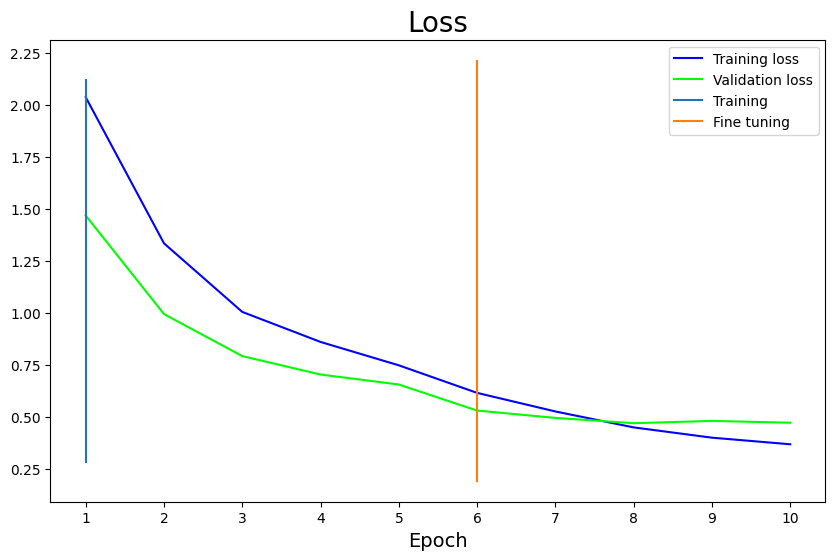

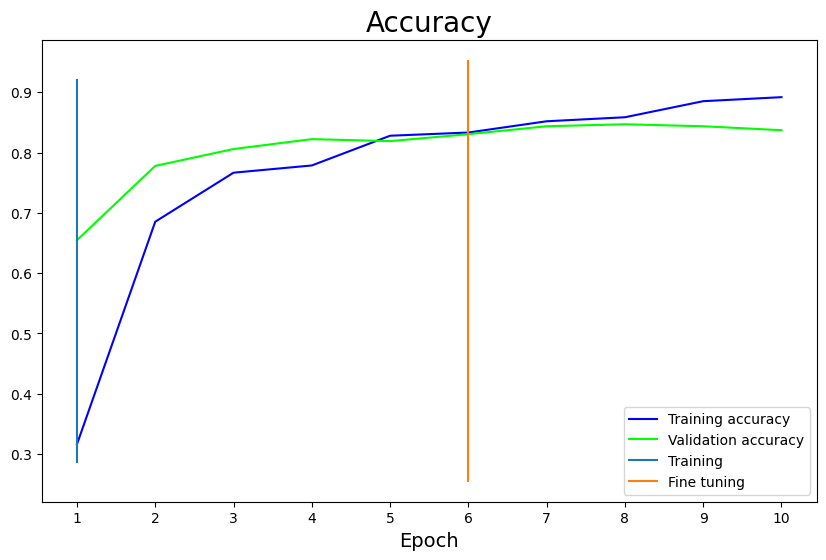

In [44]:
mlu.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_last_10], ["Training", "Fine tuning"])

## Model 4: Fine-tuning an existing model on all of the data

In [45]:
# Download and unzip 10 food classes of Food101 data with all images
mli.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip',
                   './10_food_classes_all_data.zip')
mli.extract_zip(filepath='10_food_classes_all_data.zip')
mli.list_dir_summary('./10_food_classes_all_data')

There are 2 directories, and 0 in ./10_food_classes_all_data
There are 10 directories, and 0 in ./10_food_classes_all_data/test
There are 0 directories, and 250 in ./10_food_classes_all_data/test/chicken_wings
There are 0 directories, and 250 in ./10_food_classes_all_data/test/fried_rice
There are 0 directories, and 250 in ./10_food_classes_all_data/test/ice_cream
There are 0 directories, and 250 in ./10_food_classes_all_data/test/grilled_salmon
There are 0 directories, and 250 in ./10_food_classes_all_data/test/chicken_curry
There are 0 directories, and 250 in ./10_food_classes_all_data/test/hamburger
There are 0 directories, and 250 in ./10_food_classes_all_data/test/steak
There are 0 directories, and 250 in ./10_food_classes_all_data/test/pizza
There are 0 directories, and 250 in ./10_food_classes_all_data/test/sushi
There are 0 directories, and 250 in ./10_food_classes_all_data/test/ramen
There are 10 directories, and 0 in ./10_food_classes_all_data/train
There are 0 directories, a

In [46]:
# Setup training and test dir
train_dir = './10_food_classes_all_data/train'
test_dir = './10_food_classes_all_data/test'

In [47]:
IMG_SIZE = (224, 224)

# Setup data input
train_data_all = image_dataset_from_directory(directory=train_dir,
                                              label_mode='categorical',
                                              image_size=IMG_SIZE,
                                              batch_size=32)

test_data_all = image_dataset_from_directory(directory=test_dir,
                                             label_mode='categorical',
                                             image_size=IMG_SIZE,
                                             batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we have been using in previous experiments. Let's verify this...

In [48]:
# Evaluate model_2 (this is the fine tuned on 10 percent of data version
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 84ms/step - loss: 0.4343 - accuracy: 0.8544


[0.4343104362487793, 0.8543999791145325]

In [49]:
model_2_evaluate_fine_tune_last_10

[0.4343104362487793, 0.8543999791145325]

To train a fine tuning model 4 we need to revert model_2 back to its feature extraction version

In [50]:
mll.list_model(model_2)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [51]:
# Load weights from checkpoint, that way we can fine tune from the same stage as the 10 percent data model was fine-tuned from.
mll.load_weights(model_2, '/content/checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.66.hdf5')

In [52]:
mll.list_model(model_2)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [53]:
# Let's evaluate model_2 now
model_2.evaluate(test_data_all)

79/79 [==============================] - 6s 67ms/step - loss: 0.6388 - accuracy: 0.8364


[0.6387568712234497, 0.8363999724388123]

In [54]:
# Check to see if our model has been reverted to feature extracted results.
model_2_evaluation

[0.6387568116188049, 0.8363999724388123]

Alright, the previous steps might seem quite confusing but all we have done is:

1. Train a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2), and we saved the models weights
2. Fine-tuned the same model on the same 10 percent of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. We saved the results and training logs each time.
4. Reloaded the model from step 1. To do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [55]:
# Compile

model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [56]:
# Compile

fine_tune_epochs = initial_epochs + 5

tensorboard_callback = mlc.create_tensorboard_callback("model_2_fine_tune_100_percent")

model_2_history_fine_tune_all = model_2.fit(train_data_all,
                                            steps_per_epoch=len(train_data_all),
                                            epochs=fine_tune_epochs,
                                            initial_epoch=model_2_history.epoch[-1] + 1,
                                            validation_data=test_data_all,
                                            validation_steps=int(0.25 * len(test_data_all)),
                                            callbacks=[tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_2_fine_tune_100_percent/20230511-101457
Epoch 6/10
235/235 [==============================] - 77s 298ms/step - loss: 0.6625 - accuracy: 0.7875 - val_loss: 0.3461 - val_accuracy: 0.8734
Epoch 7/10
235/235 [==============================] - 58s 244ms/step - loss: 0.5292 - accuracy: 0.8264 - val_loss: 0.3100 - val_accuracy: 0.8931
Epoch 8/10
235/235 [==============================] - 53s 224ms/step - loss: 0.4661 - accuracy: 0.8489 - val_loss: 0.3267 - val_accuracy: 0.8783
Epoch 9/10
235/235 [==============================] - 48s 202ms/step - loss: 0.4282 - accuracy: 0.8612 - val_loss: 0.3017 - val_accuracy: 0.8865
Epoch 10/10
235/235 [==============================] - 47s 196ms/step - loss: 0.3855 - accuracy: 0.8767 - val_loss: 0.2964 - val_accuracy: 0.8865


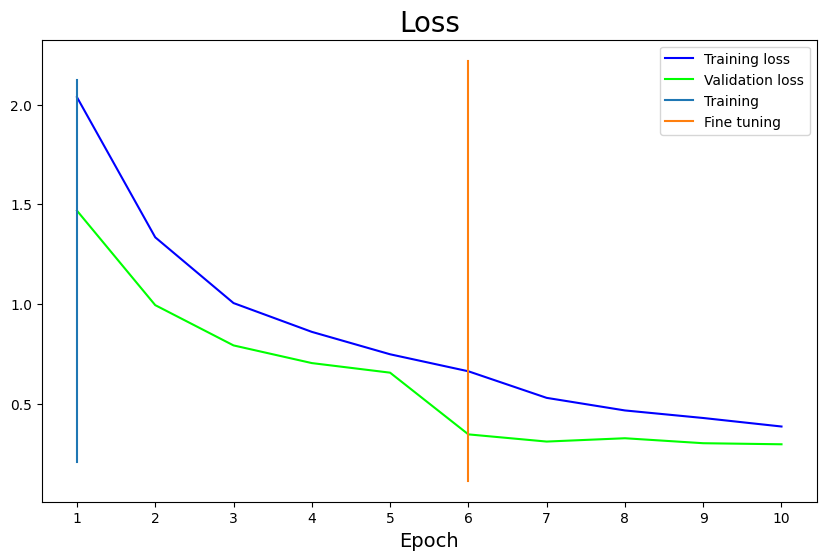

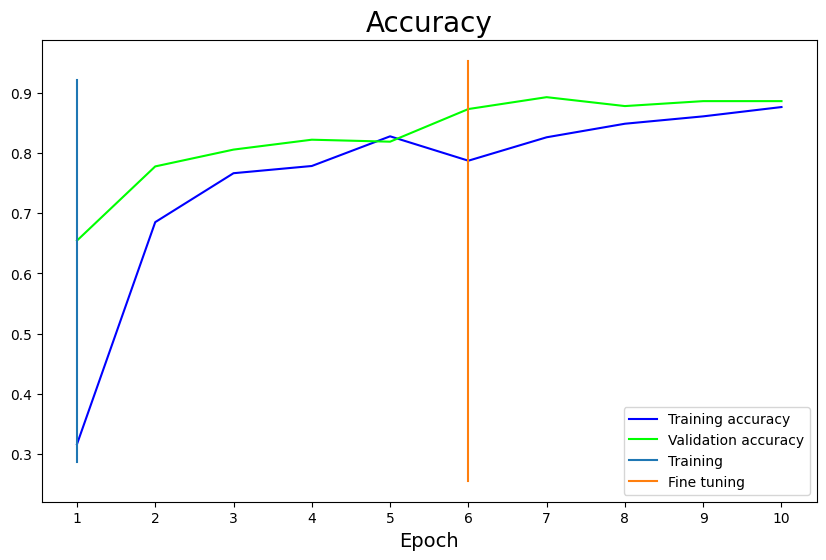

In [57]:
mlu.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_all], ["Training", "Fine tuning"])


In [58]:
model_2.evaluate(train_data_all)

235/235 [==============================] - 19s 75ms/step - loss: 0.2978 - accuracy: 0.9044


[0.29776179790496826, 0.9043999910354614]

## Try training the last 20 layers af the EfficientNetB0 model and see what the results are.

In [59]:
mll.list_model(model_2)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [60]:
# Reload the weights so we can start clean.
mll.load_weights(model_2, "/content/checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.66.hdf5")

In [61]:
mll.list_model(model_2)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [65]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [66]:
mll.load_weights(model_2, "/content/checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.66.hdf5")

In [67]:
mll.list_model(model_2)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [71]:
model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

model_2_history_fine_tune_last_20 = model_2.fit(train_data_all,
                                                steps_per_epoch=len(train_data_all),
                                                initial_epoch=model_2_history.epoch[-1] + 1,
                                                epochs=10,
                                                validation_data=test_data_all,
                                                validation_steps=int(0.25 * len(test_data_all)))

Epoch 6/10
235/235 [==============================] - 51s 185ms/step - loss: 0.6360 - accuracy: 0.7984 - val_loss: 0.3402 - val_accuracy: 0.8734
Epoch 7/10
235/235 [==============================] - 42s 175ms/step - loss: 0.4885 - accuracy: 0.8435 - val_loss: 0.2746 - val_accuracy: 0.9128
Epoch 8/10
235/235 [==============================] - 40s 169ms/step - loss: 0.4139 - accuracy: 0.8647 - val_loss: 0.2787 - val_accuracy: 0.9095
Epoch 9/10
235/235 [==============================] - 39s 165ms/step - loss: 0.3607 - accuracy: 0.8836 - val_loss: 0.2691 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 42s 173ms/step - loss: 0.3150 - accuracy: 0.8961 - val_loss: 0.2420 - val_accuracy: 0.9194


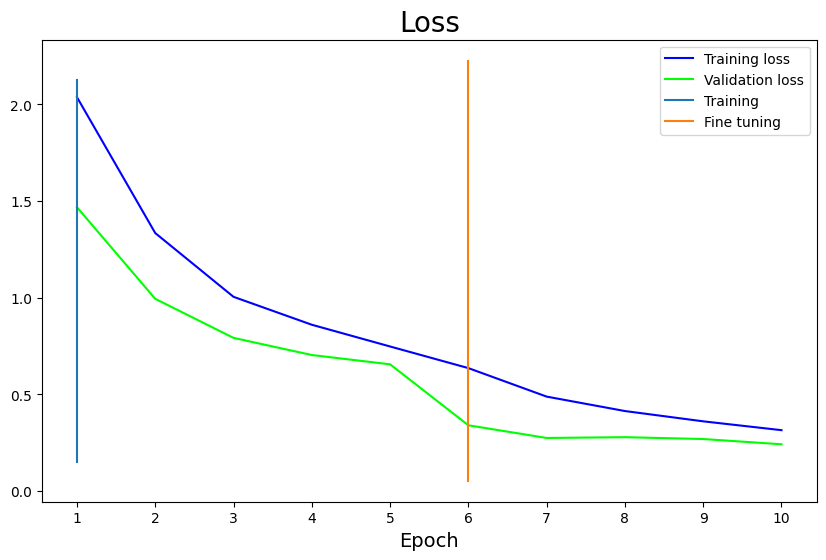

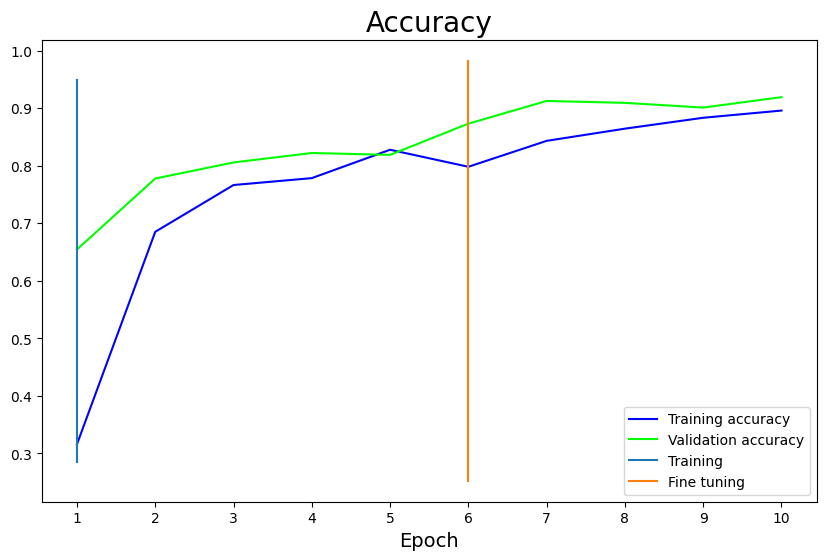

In [72]:
mlu.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_last_20], ["Training", "Fine tuning"])

In [73]:
mll.load_weights(model_2, "/content/checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.66.hdf5")

In [74]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [75]:
mll.list_model(model_2)

Row   | Name (Type)                                        | Trainable | Output Shape
0     | input_layer               (InputLayer            ) | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | False     | (None, None, None, 3)   
8     | normalization             (Normalization         ) | False     | (None, None, None, 3)   
9     | rescaling_1             

In [76]:
model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

model_2_history_fine_tune_last_30 = model_2.fit(train_data_all,
                                                steps_per_epoch=len(train_data_all),
                                                initial_epoch=model_2_history.epoch[-1] + 1,
                                                epochs=10,
                                                validation_data=test_data_all,
                                                validation_steps=int(0.25 * len(test_data_all)))

Epoch 6/10
235/235 [==============================] - 49s 163ms/step - loss: 0.6267 - accuracy: 0.7961 - val_loss: 0.3546 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 36s 152ms/step - loss: 0.4822 - accuracy: 0.8453 - val_loss: 0.2882 - val_accuracy: 0.8980
Epoch 8/10
235/235 [==============================] - 36s 153ms/step - loss: 0.4096 - accuracy: 0.8693 - val_loss: 0.2593 - val_accuracy: 0.9145
Epoch 9/10
235/235 [==============================] - 36s 152ms/step - loss: 0.3467 - accuracy: 0.8909 - val_loss: 0.2954 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 39s 166ms/step - loss: 0.2993 - accuracy: 0.9040 - val_loss: 0.2855 - val_accuracy: 0.9046


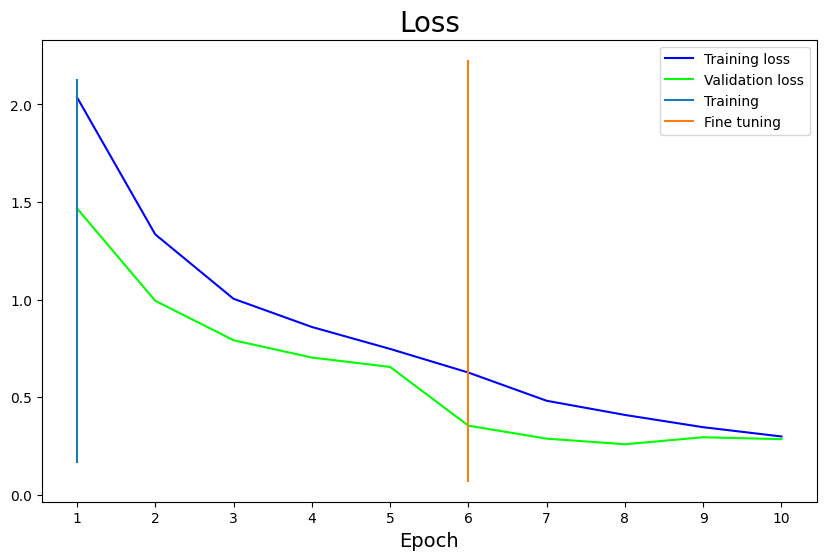

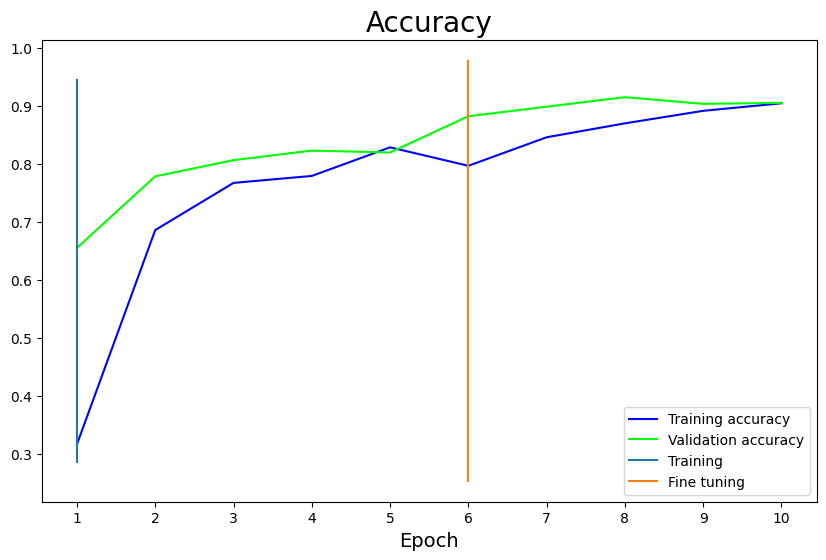

In [77]:
mlu.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_last_30], ["Training", "Fine tuning"])